In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
import os
import re
import json
import emoji
from collections import Counter
from statistics import mean, median, stdev

import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, ImageColorGenerator
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

# Import Data

In [2]:
# Read all lines

files = sorted(os.listdir('./chats/'))

chat_path = f'./chats/result.json'

with open(chat_path, encoding='utf-8') as file:
    lines = ''.join(file.readlines())

json_data = json.loads(lines)
tmp = pd.DataFrame(json_data)

# Parse Data

In [3]:
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

def day_of_week(i):
    return days_of_week[i]

def extract_emojis(s):
    return ''.join(c for c in s if str(c) in emoji.UNICODE_EMOJI)

df = pd.json_normalize(tmp.messages)
df = df[['date_unixtime', 'from', 'text']]
df = df[df['text'].str.len() > 0]
df.date_unixtime = df.date_unixtime.apply(lambda x: int(x) + 8 * 60 * 60)
df['Date'] = pd.to_datetime(df.date_unixtime, unit='s').dt.date
df['Time'] = pd.to_datetime(df.date_unixtime, unit='s').dt.time
df['MMYYYY'] = df.Date.apply(lambda x: x.strftime("%m/%Y"))
df.MMYYYY = pd.to_datetime(df.MMYYYY, format='%m/%Y')
df['Hour'] = pd.to_datetime(df.date_unixtime, unit='s').dt.hour
df['Day'] = pd.to_datetime(df.date_unixtime, unit='s').dt.weekday
df.Day = df.Day.apply(day_of_week)
df.Day = df.Day.astype('category')
df.Day.cat.reorder_categories(
    days_of_week,
    ordered=True,
    inplace=True
)
df['Message'] = df.text.apply(lambda x: str(x))
df['Emojis'] = df.Message.apply(extract_emojis)

## Anoymize users
df['User'] = [f'User {x}' for x in df['from'].factorize()[0]]
df = df[['Date', 'Time', 'MMYYYY', 'Hour', 'Day', 'User', 'Message', 'Emojis']]

df

,Date,Time,MMYYYY,Hour,Day,User,Message,Emojis
0,2023-12-12,06:57:01,2023-12-01,6,Tuesday,User 0,Eh why your Instagram no posts one,
1,2023-12-12,06:57:18,2023-12-01,6,Tuesday,User 0,Im sure you create a substantial amount of dig...,
2,2023-12-12,10:03:57,2023-12-01,10,Tuesday,User 1,hahha need to upload more right! sometimes wil...,😂
3,2023-12-12,10:04:13,2023-12-01,10,Tuesday,User 1,maybe silly content hahaha,
4,2023-12-12,10:04:25,2023-12-01,10,Tuesday,User 1,it's not rainy today at all - did you bird,
...,...,...,...,...,...,...,...,...
10296,2024-05-07,10:36:14,2024-05-01,10,Tuesday,User 0,eh i don't get the otterwatch people 😂😂😂,😂😂😂
10297,2024-05-07,10:53:41,2024-05-01,10,Tuesday,User 1,haha I don't either,
10298,2024-05-07,10:53:51,2024-05-01,10,Tuesday,User 1,they even have passports / IDs to recognise wh...,
10299,2024-05-07,10:57:35,2024-05-01,10,Tuesday,User 0,"WTF that’s insane, but then again if you’re on...",😂


# Stats

In [4]:
## Need to update list of users
users = sorted(list(set(df.User)))

for user in users:
    df_user = df[df.User == user]
    message_lengths = df_user.Message.apply(lambda x : len(x.split(' ')))   
    all_emojis = [x for y in df_user.Emojis.apply(lambda z: list(z)) for x in y if x != []]
    emoji_counts = Counter(all_emojis)

    print(f'User: {user}')
    print(f'Messages sent: {df_user.shape[0]}')
    print(f'Mean words per message: {mean(message_lengths)}')
    print(f'Median words per message: {int(median(message_lengths))}')
    print(f'Max message length: {max(message_lengths)} words')
    print(f'Standard deviation: {stdev(message_lengths)}')
    print(f'Top emojis: {[k for k, v in emoji_counts.items() if v >= 10]}')
    print()
#     print(f'Longest message:\n{df_user.loc[message_lengths == max(message_lengths)].Message.values[0]}')
#     print()

    fig = ff.create_distplot(
        hist_data=[list(filter(lambda x: x <= 50, message_lengths))], 
        group_labels=[user],
        bin_size=[1]
    )
    fig.show(renderer="iframe")
    fig.write_html(f"./plots/message_length_user_{user[-1]}.html")

User: User 0
Messages sent: 5317
Mean words per message: 9.390445740078992
Median words per message: 7
Max message length: 711 words
Standard deviation: 14.77280560008465
Top emojis: ['🌚', '😂', '😞', '🏻', '♂', '🙄', '😒', '🤔', '😏']



User: User 1
Messages sent: 4716
Mean words per message: 8.486005089058525
Median words per message: 6
Max message length: 179 words
Standard deviation: 9.149032090568253
Top emojis: ['😂', '🤣', '😭', '🤔']



## Plots

In [5]:
color_theme = [px.colors.qualitative.Plotly[i] for i in [0, 5]] 

In [6]:
fig = px.histogram(df, x='MMYYYY', color='User', color_discrete_sequence=color_theme)
fig.update_layout(bargap=0.1)
fig.show(renderer="iframe")

In [7]:
fig.write_html("./plots/count_by_MMYYY.html")

In [8]:
fig = px.histogram(df, x='Hour', color='User', color_discrete_sequence=color_theme)
fig = fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': list(range(24))})
fig.show(renderer="iframe")

In [9]:
fig.write_html("./plots/count_by_time.html")

In [10]:
fig = px.histogram(df, x='Day', color='User', color_discrete_sequence=color_theme)
fig.update_layout(bargap=0.1, xaxis={'categoryorder': 'array', 'categoryarray': days_of_week})
fig.show(renderer="iframe")

In [11]:
fig.write_html("./plots/count_by_day.html")

In [12]:
df_heatmap = df\
    .groupby(['Day', 'Hour'])\
    .Message\
    .count()\
    .reset_index()\
    .sort_values(['Hour', 'Day'], ascending=[True, False])\
    .reset_index(drop=True)\

df_heatmap

,Day,Hour,Message
0,Sunday,0,66
1,Saturday,0,31
2,Friday,0,8
3,Thursday,0,62
4,Wednesday,0,0
...,...,...,...
163,Friday,23,83
164,Thursday,23,71
165,Wednesday,23,154
166,Tuesday,23,4


In [13]:
data = [
    go.Heatmap(
        x=df_heatmap.Hour,
        y=df_heatmap.Day,
        z=df_heatmap.Message
    )
]

layout = go.Layout(title='Message Count')

fig = go.Figure(data=data, layout=layout)
fig.show(renderer="iframe")

In [14]:
fig.write_html("./plots/count_by_day_time.html")

# Word Cloud
Wrote my own n-gram parser, for fun :)

In [15]:
stop_words = set(stopwords.words('english'))

def get_frequency(df, col_name):
    text_list = list(df[col_name])
    lemmatizer = WordNetLemmatizer()
    frequency = {}
    for text in text_list:
        temp = []
        text = str(text)
        text = re.sub('[^a-zA-Z ]+', '', text)
        text = text.lower()
        text = text.split(' ')
        for word in text:
            word = lemmatizer.lemmatize(word)
            temp.append(word)
        text = ' '.join(temp)
        if text in frequency:
            frequency[text] += 1
        else:
            frequency[text] = 1
    return frequency
            
def get_ngram_frequency(df, col_name, stop_words, n):
    text_list = list(df[col_name])
    stop_words = stop_words
    lemmatizer = WordNetLemmatizer()
    frequency = {}
    for text in text_list:
        temp = []
        text = str(text)
        text = re.sub('[^a-zA-Z ]+', '', text)
        text = text.lower()
        text = text.split(' ')
        for word in text:
            if word not in stop_words:
                temp.append(word)
        for i in range(len(temp)):
            if i + n - 1 < len(temp):
                word = temp[i]
                word = lemmatizer.lemmatize(word)
                for j in range(n - 1):
                    word = word + ' ' + temp[i+j+1]
                if word in frequency:
                    frequency[word] += 1
                else:
                    frequency[word] = 1
    if '' in frequency:
        frequency[''] = 0
    return frequency

def merge_ngram_frequencies(df, col_name, stop_words, n):
    merged_dicts = {}
    for i in list(range(1, n+1)):
        temp_dict = get_ngram_frequency(df, col_name, stop_words, i)
        merged_dicts.update(temp_dict)
    return merged_dicts

def get_wordcloud(freq):
    wordcloud = WordCloud(
        background_color="white",
        width=1920,
        height=1080, 
        max_words=10000,
        relative_scaling=1,
        random_state=42
    ).generate_from_frequencies(freq)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
    return wordcloud

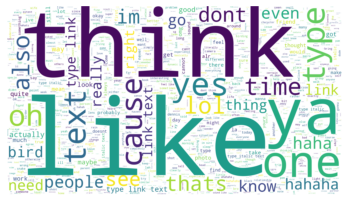

CPU times: user 7.66 s, sys: 273 ms, total: 7.93 s
Wall time: 8.02 s


In [16]:
%%time

freq = merge_ngram_frequencies(df, 'Message', stop_words, 3)
wc = get_wordcloud(freq)

In [17]:
wc.to_file('./wordclouds/wc1.png')

# Topic Analysis

In [18]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(df.Message)

lda = LDA(n_components=5, n_jobs=-1)
lda.fit(count_data)

LatentDirichletAllocation(n_components=5, n_jobs=-1)

In [19]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, 10)

Topics found via LDA:

Topic #0:
cause just like bird time think know actually photos birding

Topic #1:
like haha think people just need mean does really ic

Topic #2:
lol like hahaha ya people maybe haha la ok think

Topic #3:
think just alr don right time omg ya xy hahahaha

Topic #4:
oh ya yes type text link https com www just


# Sentiment Analysis

In [20]:
def get_sentiment(message):
    return mean(x.sentiment.polarity for x in TextBlob(message).sentences)

In [21]:
%%time

df['Sentiment'] = df.Message.apply(lambda x: get_sentiment(x))

CPU times: user 1.05 s, sys: 15.7 ms, total: 1.06 s
Wall time: 1.06 s


In [22]:
hhmm_list = pd.date_range('00:00', '23:59', freq='1min').time

for user in users:
    df_sentiments = df[df.User == user][['Date', 'Sentiment', 'User']].groupby(['Date', 'User']).mean()
    df_sentiments.reset_index(inplace=True)

    fig = px.bar(df_sentiments, x='Date', y='Sentiment', color='User', color_discrete_sequence=color_theme)
    fig.update_layout(xaxis={'categoryorder': 'array', 'categoryarray': hhmm_list})
    fig.write_html(f"./plots/sentiments_user_{user[-1]}.html")
    fig.show(renderer="iframe")